In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from tqdm import tqdm
%matplotlib inline
test_path = 'https://media.githubusercontent.com/media/cchopade/gahack2/master/test.csv'
train_path = 'https://media.githubusercontent.com/media/cchopade/gahack2/master/train.csv'

In [130]:
#df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
#df_train.Datetime = pd.to_datetime(df_train.Datetime)

df_train=pd.read_csv(train_path,index_col='Datetime',parse_dates=True)
df_train.drop(labels = 'ID', axis = 1)
df_train.head()

,ID,Item_ID,Category_3,Category_2,Category_1,Price,Number_Of_Sales
Datetime,,,,,,,
2014-01-01,30495_20140101,30495,0,2.0,90,165.123,1
2014-01-01,30375_20140101,30375,0,2.0,307,68.666,5
2014-01-01,30011_20140101,30011,0,3.0,67,253.314,2
2014-01-01,30864_20140101,30864,0,2.0,315,223.122,1
2014-01-01,30780_20140101,30780,1,2.0,132,28.750,1


In [76]:
df_train.columns

Index(['ID', 'Item_ID', 'Category_3', 'Category_2', 'Category_1', 'Price',
       'Number_Of_Sales'],
      dtype='object')

In [84]:
df_train.groupby(['Datetime','Item_ID'])['Price']

In [139]:
df_try = df_train.pivot_table(index = ['Datetime','Item_ID'], values = 'Price')

In [140]:
df = pd.read_csv(train_path)
df.Datetime = pd.to_datetime(df.Datetime)

In [141]:
df = df.set_index(['Item_ID','Datetime'])

In [142]:
df

,,ID,Category_3,Category_2,Category_1,Price,Number_Of_Sales
Item_ID,Datetime,,,,,,
30495,2014-01-01,30495_20140101,0,2.0,90,165.123,1
30375,2014-01-01,30375_20140101,0,2.0,307,68.666,5
30011,2014-01-01,30011_20140101,0,3.0,67,253.314,2
30864,2014-01-01,30864_20140101,0,2.0,315,223.122,1
30780,2014-01-01,30780_20140101,1,2.0,132,28.750,1
30927,2014-01-01,30927_20140101,0,1.0,38,4.345,402
31342,2014-01-01,31342_20140101,0,2.0,38,2.874,832
30540,2014-01-01,30540_20140101,0,3.0,38,3.123,423
29999,2014-01-01,29999_20140101,0,3.0,67,7.286,133


In [147]:
df = df.sort_index(ascending=False)

#df = df.sort_values('Datetime', ascending = False)

In [154]:
df.sort_values(['Item_ID','Datetime'],ascending=[False,True],inplace=True)

In [158]:
df.reset_index(inplace=True)

In [183]:
item1 = df[df.Item_ID == 30132]

In [184]:
item1.set_index(item1.Datetime,inplace=True)

In [185]:
ts = item1.iloc[:,-2]

In [186]:
ts

Datetime
2014-07-12    2.509
2014-07-13    1.921
2014-07-14    1.580
2014-07-15    1.337
2014-07-16    1.150
2014-07-17    1.060
2014-07-18    0.938
2014-07-19    0.887
2014-07-20    0.751
2014-07-21    0.702
2014-07-22    0.701
2014-07-23    0.684
2014-07-24    0.640
2014-07-25    0.722
2014-07-26    0.701
2014-07-27    0.704
2014-07-28    0.689
2014-07-29    0.637
2014-07-30    0.592
2014-07-31    0.524
2014-08-01    0.575
2014-08-02    0.621
2014-08-03    0.588
2014-08-04    0.544
2014-08-05    0.465
2014-08-06    0.427
2014-08-07    0.412
2014-08-08    0.411
2014-08-09    0.417
2014-08-10    0.394
              ...  
2016-06-01    0.377
2016-06-02    0.367
2016-06-03    0.362
2016-06-04    0.363
2016-06-05    0.348
2016-06-06    0.351
2016-06-07    0.346
2016-06-08    0.359
2016-06-09    0.357
2016-06-10    0.369
2016-06-11    0.369
2016-06-12    0.366
2016-06-13    0.339
2016-06-14    0.327
2016-06-15    0.347
2016-06-16    0.346
2016-06-17    0.311
2016-06-18    0.308
2016-06-19 

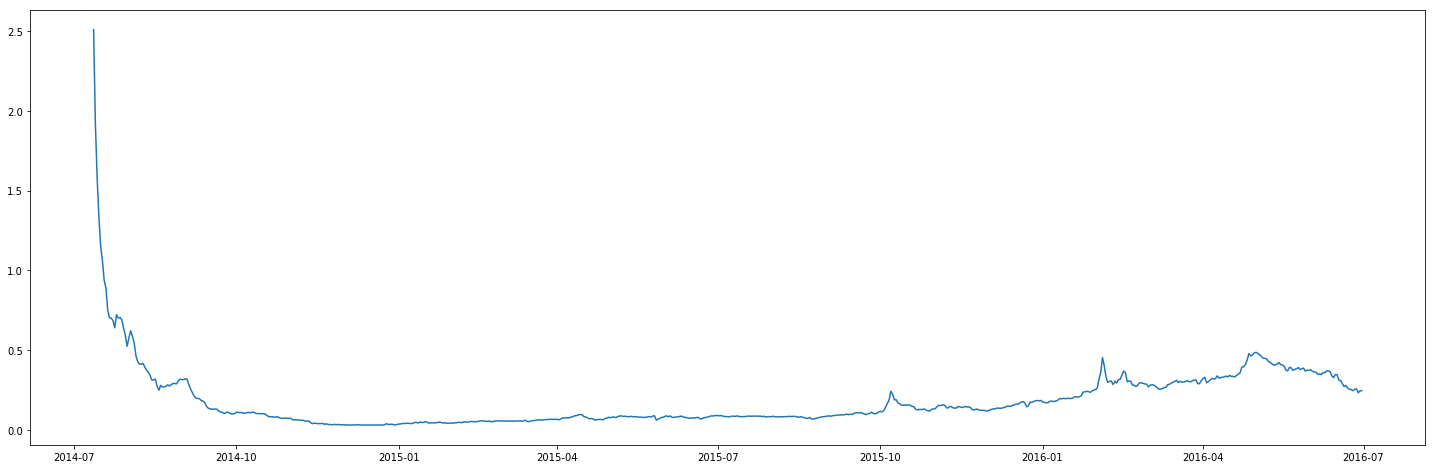

In [188]:
plt.figure(figsize=(25,8))
plt.plot(item1.index, item1.Price)